In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
data = pd.read_csv('GazeDataPilot\gaze_data_all_trials.csv', sep=',')

# Define screen resolution (you can adjust this based on Unity's settings)
screen_width = 2560
screen_height = 1440

In [ ]:
! pip install numpy
! pip install scipy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute Eye Movement Velocity using Relative Time
def compute_velocity(df):
    # Calculate time difference instead of frame difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second
    return df

# Step 2: Compute Accuracy Relative to the Ball Position (separate X and Y)
def compute_accuracy(df, screen_width, screen_height):
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])
    return df

# Step 3: Align time values and average across trials of the same type (trialID)
def align_and_average_across_trials(df, screen_width, screen_height):
    # Align Time: Create RelativeTime for each trial, starting at 0
    df['RelativeTime'] = df.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Find the maximum duration (relative time) for each trialID
    max_duration = df.groupby('TrialID')['RelativeTime'].max().max()

    # Step 4: Interpolate missing values for shorter trials
    all_relative_times = pd.DataFrame({'RelativeTime': np.arange(0, max_duration, 0.01)})  # Example resolution of 10ms
    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]
        
        # Align and interpolate each trial by trial ID
        avg_by_trial_id = trial_data.groupby('RelativeTime').agg(
            AvgVelocity=('Velocity', 'mean'),
            AvgAccuracyX=('AccuracyX', 'mean'),
            AvgAccuracyY=('AccuracyY', 'mean')
        ).reset_index()

        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 5: Plot the aligned and averaged metrics by selected trialIDs
def plot_aligned_average_metrics_by_trialID(avg_df, trial_ids, screen_width, screen_height):
    filtered_df = avg_df[avg_df['TrialID'].isin(trial_ids)]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]
    unique_trial_ids = sorted(filtered_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(unique_trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(unique_trial_ids):
        trial_avg = filtered_df[filtered_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['RelativeTime'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.set_ylabel('Avg Velocity (pixels/sec)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 150])
        ax_velocity.set_xlabel('Relative Time (s)')

        # Plot average Accuracy (X) in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['RelativeTime'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Relative Time (s)')

        # Plot average Accuracy (Y) in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['RelativeTime'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Relative Time (s)')

    fig.tight_layout()
    plt.show()

# Step 6: Align, average, and plot metrics with selected trialIDs
selected_trial_ids = [0, 1, 2, 3]  # Example list of trial IDs to plot
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, selected_trial_ids, screen_width, screen_height)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute Eye Movement Velocity using Relative Time
def compute_velocity(df):
    # Calculate time difference instead of frame difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second
    return df

# Step 2: Compute Accuracy Relative to the Ball Position (separate X and Y)
def compute_accuracy(df, screen_width, screen_height):
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])
    return df

# Step 3: Align time values, normalize to [0, 1], and average across trials of the same type (trialID)
def align_and_average_across_trials(df, screen_width, screen_height, trial_ids=None):
    # Filter DataFrame to include only specified trial IDs
    if trial_ids is not None:
        df = df[df['TrialID'].isin(trial_ids)]
    
    # Align Time: Create RelativeTime for each trial, starting at 0
    df['RelativeTime'] = df.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Normalize Relative Time to the range [0, 1]
    df['MaxRelativeTime'] = df.groupby('TrialNumber')['RelativeTime'].transform('max')
    df['NormalizedTime'] = df['RelativeTime'] / df['MaxRelativeTime']

    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]

        # Now average across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedTime').agg(
            AvgVelocity=('Velocity', 'mean'),
            AvgAccuracyX=('AccuracyX', 'mean'),
            AvgAccuracyY=('AccuracyY', 'mean')
        ).reset_index()

        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 4: Plot the aligned and averaged metrics by trialID
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height, trial_ids=None):
    # Filter avg_df to include only specified trial IDs
    if trial_ids is not None:
        avg_df = avg_df[avg_df['TrialID'].isin(trial_ids)]
    
    unique_trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(unique_trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(unique_trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedTime'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.set_ylabel('Avg Velocity (pixels/sec)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 150])
        ax_velocity.set_xlabel('Normalized Time')

        # Plot average Accuracy (X) in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedTime'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Normalized Time')

        # Plot average Accuracy (Y) in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedTime'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Normalized Time')

    fig.tight_layout()
    plt.show()

# Step 5: Align, average, and plot metrics with selected trialIDs and normalized time values
selected_trial_ids = [0, 1, 2, 3]  # Example list of trial IDs to plot
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height, trial_ids=selected_trial_ids)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height, trial_ids=selected_trial_ids)


MSE plots

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute Eye Movement Velocity using Relative Time
def compute_velocity(df):
    # Calculate time difference instead of frame difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second
    return df

# Step 2: Compute Accuracy Relative to the Ball Position (separate X and Y)
def compute_accuracy(df, screen_width, screen_height):
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])
    return df

# Step 3: Align time values, normalize to [0, 1], and average across trials of the same type (trialID) with MSE
def align_and_average_across_trials(df, screen_width, screen_height, trial_ids=None):
    # Filter DataFrame to include only specified trial IDs
    if trial_ids is not None:
        df = df[df['TrialID'].isin(trial_ids)]
    
    # Align Time: Create RelativeTime for each trial, starting at 0
    df['RelativeTime'] = df.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Normalize Relative Time to the range [0, 1]
    df['MaxRelativeTime'] = df.groupby('TrialNumber')['RelativeTime'].transform('max')
    df['NormalizedTime'] = df['RelativeTime'] / df['MaxRelativeTime']

    # Interpolate missing values for shorter trials with 100 points
    all_normalized_times = pd.DataFrame({'NormalizedTime': np.linspace(0, 1, num=100)})
    
    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]
    
        # Calculate mean and MSE across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedTime').agg(
            AvgVelocity=('Velocity', 'mean'),
            MSEVelocity=('Velocity', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyX=('AccuracyX', 'mean'),
            MSEAccuracyX=('AccuracyX', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyY=('AccuracyY', 'mean'),
            MSEAccuracyY=('AccuracyY', lambda x: np.mean((x - x.mean())**2))
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 4: Plot the aligned and averaged metrics by trialID with MSE regions
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height, trial_ids=None):
    # Filter avg_df to include only specified trial IDs
    if trial_ids is not None:
        avg_df = avg_df[avg_df['TrialID'].isin(trial_ids)]
    
    unique_trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(unique_trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(unique_trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity and MSE region in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedTime'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.fill_between(trial_avg['NormalizedTime'],
                                 trial_avg['AvgVelocity'] - np.sqrt(trial_avg['MSEVelocity']),
                                 trial_avg['AvgVelocity'] + np.sqrt(trial_avg['MSEVelocity']),
                                 color='blue', alpha=0.2, label='MSE Region')
        ax_velocity.set_ylabel('Avg Velocity (pixels/sec)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 150])
        ax_velocity.set_xlabel('Normalized Time')

        # Plot average Accuracy (X) and MSE region in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedTime'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.fill_between(trial_avg['NormalizedTime'],
                                   trial_avg['AvgAccuracyX'] - np.sqrt(trial_avg['MSEAccuracyX']),
                                   trial_avg['AvgAccuracyX'] + np.sqrt(trial_avg['MSEAccuracyX']),
                                   color='green', alpha=0.2, label='MSE Region')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Normalized Time')

        # Plot average Accuracy (Y) and MSE region in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedTime'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.fill_between(trial_avg['NormalizedTime'],
                                   trial_avg['AvgAccuracyY'] - np.sqrt(trial_avg['MSEAccuracyY']),
                                   trial_avg['AvgAccuracyY'] + np.sqrt(trial_avg['MSEAccuracyY']),
                                   color='red', alpha=0.2, label='MSE Region')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Normalized Time')

    fig.tight_layout()
    plt.show()

# Step 5: Align, average, and plot metrics with selected trialIDs, normalized time, and MSE regions
selected_trial_ids = [0, 1, 2, 3]  # Example list of trial IDs to plot
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height, trial_ids=selected_trial_ids)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height, trial_ids=selected_trial_ids)


individual trials


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compute_velocity_and_accuracy(df, screen_width, screen_height):
    # Compute Time Difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero

    # Compute Position Difference for Velocity
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second

    # Compute Accuracy Relative to Ball Position
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column, handling negative values
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    # Filter out rows where BallX or BallY is negative
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]

    # Calculate Accuracy in X and Y directions
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])

    return df

# Function to plot individual trials within a given range for a specific TrialID using RelativeTime
def plot_individual_trials(df, trial_id, trial_range=(0, 4)):
    # Filter the data for the specified TrialID
    trial_data = df[df['TrialID'] == trial_id]

    # Get the unique trial numbers within the specified range
    trial_numbers = trial_data['TrialNumber'].unique()
    start, end = trial_range
    selected_trials = trial_numbers[start:end+1]  # Select trials within the range

    # Create a figure for each trial in the range
    fig, axes = plt.subplots(len(selected_trials), 3, figsize=(15, 5 * len(selected_trials)), sharex=True)
    fig.suptitle(f'Individual Trials for TrialID: {trial_id}', fontsize=16)
    
    for i, trial_num in enumerate(selected_trials):
        single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]

        # Ensure we can handle subplots when there's only one row
        if len(selected_trials) == 1:
            axes_row = axes
        else:
            axes_row = axes[i]

        # Plot Velocity
        axes_row[0].plot(single_trial_data['RelativeTime'], single_trial_data['Velocity'], color='blue')
        axes_row[0].set_title(f'TrialNumber: {trial_num} - Velocity')
        axes_row[0].set_ylabel('Velocity (pixels/sec)')
        axes_row[0].set_xlabel('Relative Time (s)')
        axes_row[0].set_ylim([0, 200])

        # Plot Accuracy X
        axes_row[1].plot(single_trial_data['RelativeTime'], single_trial_data['AccuracyX'], color='green')
        axes_row[1].set_title(f'TrialNumber: {trial_num} - Accuracy X')
        axes_row[1].set_ylabel('Accuracy X (pixels)')
        axes_row[1].set_xlabel('Relative Time (s)')
        axes_row[1].set_ylim([0, 1500])

        # Plot Accuracy Y
        axes_row[2].plot(single_trial_data['RelativeTime'], single_trial_data['AccuracyY'], color='red')
        axes_row[2].set_title(f'TrialNumber: {trial_num} - Accuracy Y')
        axes_row[2].set_ylabel('Accuracy Y (pixels)')
        axes_row[2].set_xlabel('Relative Time (s)')
        axes_row[2].set_ylim([0, 1500])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Example usage
# Create RelativeTime for each trial, starting at 0
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# Compute velocity and accuracy
data = compute_velocity_and_accuracy(data, screen_width, screen_height)

# Plot individual trials
plot_individual_trials(data, trial_id=4, trial_range=(0, 9))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_individual_trials_with_object_position_auto_zoom(df, trial_ids=None, alpha=0.6):
    # Filter DataFrame to include only specified trial IDs if provided
    if trial_ids is not None:
        df = df[df['TrialID'].isin(trial_ids)]

    # Ensure data is sorted by TrialID and RelativeTime
    df = df.sort_values(by=['TrialID', 'RelativeTime'])

    # Get unique TrialIDs to plot
    trial_ids = df['TrialID'].unique()
    num_trials = len(trial_ids)
    
    # Set up the grid for subplots with 3 columns
    num_cols = 3
    num_rows = (num_trials + num_cols - 1) // num_cols  # Calculate rows based on the number of trials
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Plot each TrialID in a separate subplot
    for i, trial_id in enumerate(trial_ids):
        # Get the correct axis for the current TrialID
        ax = axes[i]

        # Filter the data for the current TrialID
        trial_data = df[df['TrialID'] == trial_id]
        
        # Plot each individual trial for the current TrialID
        for trial_num in trial_data['TrialNumber'].unique():
            single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
            ax.plot(single_trial_data['RelativeTime'], single_trial_data['MappedPogX'],
                    color=f"C{i}", label=f'Trial {trial_num}' if trial_num == trial_data['TrialNumber'].unique()[0] else "", alpha=alpha)
        
        # Plot the absolute object position X as a black line
        ax.plot(trial_data['RelativeTime'], trial_data['BallX'], color='black', linestyle='--', label='Object X Position')
        
        # Set individual plot limits based on min and max values for each TrialID
        x_min, x_max = trial_data['RelativeTime'].min(), trial_data['RelativeTime'].max()
        y_min, y_max = trial_data['MappedPogX'].min(), trial_data['MappedPogX'].max()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(-1000, 4000)

        # Customize each subplot
        ax.set_title(f'TrialID: {trial_id}')
        ax.set_xlabel("Relative Time (s)")
        ax.set_ylabel("Mapped X Position (pixels)")
        ax.grid(True)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust layout to fit the legend outside
    plt.show()

# Example usage
# Specify the trial IDs to plot
selected_trial_ids = [0, 12, 24, 36, 48, 60, 72, 84, 96]  # Example list of trial IDs to plot

# Create RelativeTime for each trial, starting at 0
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# Compute velocity and accuracy
data = compute_velocity_and_accuracy(data, screen_width, screen_height)

# Plot individual trials
plot_individual_trials_with_object_position_auto_zoom(data, trial_ids=selected_trial_ids, alpha=0.6)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_combined_trials_with_object_position_auto_zoom(df, trial_id_groups=None, alpha=0.6):
    # Flatten and filter DataFrame based on all trial IDs in the list of lists
    if trial_id_groups is not None:
        all_trial_ids = [trial_id for sublist in trial_id_groups for trial_id in sublist]
        df = df[df['TrialID'].isin(all_trial_ids)]

    # Ensure data is sorted by TrialID and RelativeTime
    df = df.sort_values(by=['TrialID', 'RelativeTime'])

    # Set up the grid for subplots with 3 columns
    num_cols = 3
    num_rows = (len(trial_id_groups) + num_cols - 1) // num_cols  # Calculate rows based on number of groups
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten to make indexing easier

    # Plot each group of TrialIDs in a separate subplot
    for i, trial_id_group in enumerate(trial_id_groups):
        # Get the correct axis for the current group
        ax = axes[i]

        # Plot each individual trial in the current group
        for trial_id in trial_id_group:
            # Filter the data for the current TrialID
            trial_data = df[df['TrialID'] == trial_id]

            # Plot each individual trial for the current TrialID in the group
            for trial_num in trial_data['TrialNumber'].unique():
                single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
                ax.plot(single_trial_data['RelativeTime'], single_trial_data['MappedPogX'],
                        label=f'Trial {trial_num}', alpha=alpha)

            # Plot the absolute object position X as a black line
            ax.plot(trial_data['RelativeTime'], trial_data['BallX'], color='black', linestyle='--', label='Object X Position')
        
        # Set individual plot limits based on min and max values for the group
        group_data = df[df['TrialID'].isin(trial_id_group)]
        x_min, x_max = group_data['RelativeTime'].min(), group_data['RelativeTime'].max()
        y_min, y_max = group_data['MappedPogX'].min(), group_data['MappedPogX'].max()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(-1000, 4000)

        # Customize each subplot
        ax.set_title(f'Trial Group: {trial_id_group}')
        ax.set_xlabel("Relative Time (s)")
        ax.set_ylabel("Mapped X Position (pixels)")
        ax.grid(True)

    # Remove empty subplots if any
    for j in range(len(trial_id_groups), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust layout to fit the legend outside
    plt.show()

# Example usage
# Specify the groups of trial IDs to plot
trial_id_groups = [
    [9, 21, 33], 
    [45, 57, 69], 
    [81, 93, 105]
]  # Each inner list represents a group of TrialIDs to be plotted together

# Create RelativeTime for each trial, starting at 0
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# Compute velocity and accuracy
data = compute_velocity_and_accuracy(data, screen_width, screen_height)

# Plot combined trials
plot_combined_trials_with_object_position_auto_zoom(data, trial_id_groups=trial_id_groups, alpha=0.6)


x and y plots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_velocity_and_accuracy(df, screen_width, screen_height):
    # Compute Time Difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero

    # Compute Position Difference for Velocity
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second

    # Compute Accuracy Relative to Ball Position
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column, handling negative values
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    # Filter out rows where BallX or BallY is negative
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]

    # Calculate Accuracy in X and Y object_directions
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])

    return df

# Data structure to organize pair conditions
pair_conditions = {
    "diagonal_with_y1": {
        "left_to_right": ["diagonal_left_up_y1", "diagonal_left_down_y1"],
        "right_to_left": ["diagonal_right_up_y1", "diagonal_right_down_y1"]
    },
    "diagonal_against_y1": {
        "left_to_right": ["diagonal_right_up_y1", "diagonal_right_down_y1"],
        "right_to_left": ["diagonal_left_up_y1", "diagonal_left_down_y1"]
    },
    "diagonal_with_y2": {
        "left_to_right": ["diagonal_left_up_y2", "diagonal_left_down_y2"],
        "right_to_left": ["diagonal_right_up_y2", "diagonal_right_down_y2"]
    },
    "diagonal_against_y2": {
        "left_to_right": ["diagonal_right_up_y2", "diagonal_right_down_y2"],
        "right_to_left": ["diagonal_left_up_y2", "diagonal_left_down_y2"]
    },
    "vertical": {
        "left_to_right": ["vertical_up", "vertical_down"],
        "right_to_left": ["vertical_up", "vertical_down"]
    },
    "horizontal_with": {
        "left_to_right": ["horizontal_left"],
        "right_to_left": ["horizontal_right"]
    },
    "horizontal_against": {
        "left_to_right": ["horizontal_right"],
        "right_to_left": ["horizontal_left"]
    },
    "zero": {
        "left_to_right": ["zero"],
        "right_to_left": ["zero"]
    }
}


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the trial details CSV
data = pd.read_csv('GazeDataPilot\gaze_data_all_trials_y_pilot_jenna.csv', sep=',')
trial_details_df = pd.read_csv("generated_trials_ids_y_pilot.csv")
# Function to check if a trial ID matches a specific condition, object speed, and camera speed
def get_matching_trials(condition, pair_conditions, trial_details_df, obj_speed, cam_speed):
    matching_trials = {'left_to_right': [], 'right_to_left': []}
    for _, trial in trial_details_df.iterrows():
        object_motion = trial['object_motion_type']
        camera_motion = trial['camera_motion_type']
        
        # Check if the trial matches the left_to_right or right_to_left condition with the specified speeds
        if trial['object_speed'] == obj_speed and trial['camera_speed'] == cam_speed:
            for direction, motion_types in pair_conditions[condition].items():
                if object_motion == direction and camera_motion in motion_types:
                    matching_trials[direction].append(trial['trial_id'])
    return matching_trials

def plot_condition_speed_pairs(df, pair_conditions, trial_details_df, alpha=0.6):
    # Colors for different directions
    direction_colors = {'left_to_right': 'blue', 'right_to_left': 'red'}
    
    # Get unique object speeds and camera speeds
    obj_speeds = sorted(trial_details_df['object_speed'].unique())
    cam_speeds = sorted(trial_details_df['camera_speed'].unique())
    # Iterate over each condition in pair_conditions
    for condition in pair_conditions:
        # Set up the grid of subplots with camera speeds as rows and object speeds as columns
        fig, axes = plt.subplots(len(cam_speeds), len(obj_speeds), figsize=(10, 10), sharex=False, sharey=True)
        fig.suptitle(f"Condition: {condition}", fontsize=16)
        
        if len(cam_speeds) == 1:
            axes = np.expand_dims(axes, axis=0)
        if len(obj_speeds) == 1:
            axes = np.expand_dims(axes, axis=1)
        for row, cam_speed in enumerate(cam_speeds):
            for col, obj_speed in enumerate(obj_speeds):
                # Get matching trial IDs for left_to_right and right_to_left based on the condition and speeds
                matching_trials = get_matching_trials(condition, pair_conditions, trial_details_df, obj_speed, cam_speed)
                
                # Check if there are any matching trials; skip if none
                if not any(matching_trials.values()):
                    axes[row, col].axis('off')  # Hide empty plots
                    continue
                
                # Select the current axes for X positions
                ax_x = axes[row, col]

                # Plot trials for each direction in the same plot for this condition and speed combination
                for direction, trial_ids in matching_trials.items():
                    color = direction_colors[direction]  # Set color based on direction
                    for trial_id in trial_ids:
                        # Filter data for the current trial ID and make a copy
                        trial_data = df[df['TrialID'] == trial_id].copy()
                        
                        # Flip X positions only for right_to_left direction
                        if direction == 'right_to_left':
                            trial_data['MappedPogX'] = -trial_data['MappedPogX'] + 2560
                            trial_data['BallX'] = -trial_data['BallX'] + 2560
                        
                        # Plot each individual trial in the direction
                        for trial_num in trial_data['TrialNumber'].unique():
                            single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
                            ax_x.plot(single_trial_data['RelativeTime'], single_trial_data['MappedPogX'],
                                      color=color, label=f"{direction.replace('_', ' ').title()}" if trial_num == trial_data['TrialNumber'].unique()[0] else "", alpha=alpha)
                        
                        # Plot the absolute object position X as black dashed lines
                        ax_x.plot(trial_data['RelativeTime'], trial_data['BallX'], color='black', linestyle='--', label='Object X Position' if trial_id == trial_ids[0] else "")
                
                # Customize the X subplot
                ax_x.set_title(f"Cam Speed: {cam_speed} | Obj Speed: {obj_speed} (X)")
                ax_x.set_xlabel("Relative Time (s)")
                ax_x.set_ylabel("Mapped X Position (pixels)")
                ax_x.set_xlim(0, max(trial_data['RelativeTime']))  # Time limit based on max time for this trial
                ax_x.set_ylim(-0, 2560)  # Set distinct y-axis limits for X position
        
        # Add a legend for the figure, showing the color mapping
        handles, labels = axes[0, 0].get_legend_handles_labels()
        # fig.legend(handles, labels, loc="upper right")
        
        # Adjust layout and show the plot
        fig.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for title and legend
        plt.show()

# Example usage
# Create RelativeTime for each trial, starting at 0
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
data = data[data['BestPogValid'] == True]

# Compute velocity and accuracy
data = compute_velocity_and_accuracy(data, screen_width, screen_height)

# Plot pairs based on condition pairs, object speed, and camera speed, with color differentiation
plot_condition_speed_pairs(data, pair_conditions, trial_details_df, alpha=0.3)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the trial details CSV
data = pd.read_csv('GazeDataPilot\gaze_data_all_trials_velocity_pilot_jenna.csv', sep=',')
trial_details_df = pd.read_csv("generated_trials_ids_velocity_pilot.csv")
# Function to check if a trial ID matches a specific condition, object speed, and camera speed
def get_matching_trials(condition, pair_conditions, trial_details_df, obj_speed, cam_speed):
    matching_trials = {'left_to_right': [], 'right_to_left': []}
    for _, trial in trial_details_df.iterrows():
        object_motion = trial['object_motion_type']
        camera_motion = trial['camera_motion_type']
        
        # Check if the trial matches the left_to_right or right_to_left condition with the specified speeds
        if trial['object_speed'] == obj_speed and trial['camera_speed'] == cam_speed:
            for direction, motion_types in pair_conditions[condition].items():
                if object_motion == direction and camera_motion in motion_types:
                    matching_trials[direction].append(trial['trial_id'])
    return matching_trials

def plot_condition_speed_pairs(df, pair_conditions, trial_details_df, alpha=0.6):
    # Colors for different directions
    direction_colors = {'left_to_right': 'blue', 'right_to_left': 'red'}
    
    # Get unique object speeds and camera speeds
    obj_speeds = sorted(trial_details_df['object_speed'].unique())
    cam_speeds = sorted(trial_details_df['camera_speed'].unique())
    
    # Iterate over each condition in pair_conditions
    for condition in pair_conditions:
        # Set up the grid of subplots with camera speeds as rows and object speeds as columns
        fig, axes = plt.subplots(len(cam_speeds), len(obj_speeds), figsize=(15, 10), sharex=False, sharey=True)
        fig.suptitle(f"Condition: {condition}", fontsize=16)
        if len(cam_speeds) == 1:
            axes = np.expand_dims(axes, axis=0)
        if len(obj_speeds) == 1:
            axes = np.expand_dims(axes, axis=1)
        
        for row, cam_speed in enumerate(cam_speeds):
            for col, obj_speed in enumerate(obj_speeds):
                # Get matching trial IDs for left_to_right and right_to_left based on the condition and speeds
                matching_trials = get_matching_trials(condition, pair_conditions, trial_details_df, obj_speed, cam_speed)
                
                # Check if there are any matching trials; skip if none
                if not any(matching_trials.values()):
                    axes[row, col].axis('off')  # Hide empty plots
                    continue
                
                # Select the current axes for X positions
                ax_x = axes[row, col]

                # Plot trials for each direction in the same plot for this condition and speed combination
                for direction, trial_ids in matching_trials.items():
                    color = direction_colors[direction]  # Set color based on direction
                    for trial_id in trial_ids:
                        # Filter data for the current trial ID and make a copy
                        trial_data = df[df['TrialID'] == trial_id].copy()

                        # Plot each individual trial in the direction
                        for trial_num in trial_data['TrialNumber'].unique():
                            single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
                            ax_x.plot(single_trial_data['RelativeTime'], single_trial_data['MappedPogY'],
                                      color=color, label=f"{direction.replace('_', ' ').title()}" if trial_num == trial_data['TrialNumber'].unique()[0] else "", alpha=alpha)
                        
                        # Plot the absolute object position X as black dashed lines
                        ax_x.plot(trial_data['RelativeTime'], trial_data['BallY'], color='black', linestyle='--', label='Object Y Position' if trial_id == trial_ids[0] else "")
                
                # Customize the X subplot
                ax_x.set_title(f"Cam Speed: {cam_speed} | Obj Speed: {obj_speed} (Y)")
                ax_x.set_xlabel("Relative Time (s)")
                ax_x.set_ylabel("Mapped Y Position (pixels)")
                ax_x.set_xlim(0, max(trial_data['RelativeTime']))  # Time limit based on max time for this trial
                ax_x.set_ylim(400, 1100)  # Set distinct y-axis limits for X position
        
        # Add a legend for the figure, showing the color mapping
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1, 1))
        
        # Adjust layout and show the plot
        fig.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for title and legend
        plt.show()

# Example usage
# Create RelativeTime for each trial, starting at 0
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
data = data[data['BestPogValid'] == True]

# Compute velocity and accuracy
data = compute_velocity_and_accuracy(data, screen_width, screen_height)

# Plot pairs based on condition pairs, object speed, and camera speed, with color differentiation
plot_condition_speed_pairs(data, pair_conditions, trial_details_df, alpha=0.3)


In [264]:
pair_conditions = {
    "diagonal_with_y1": {
        "left_to_right": ["diagonal_left_up_y1", "diagonal_left_down_y1"],
        "right_to_left": ["diagonal_right_up_y1", "diagonal_right_down_y1"]
    },
    "diagonal_against_y1": {
        "left_to_right": ["diagonal_right_up_y1", "diagonal_right_down_y1"],
        "right_to_left": ["diagonal_left_up_y1", "diagonal_left_down_y1"]
    },
    "diagonal_with_y2": {
        "left_to_right": ["diagonal_left_up_y2", "diagonal_left_down_y2"],
        "right_to_left": ["diagonal_right_up_y2", "diagonal_right_down_y2"]
    },
    "diagonal_against_y2": {
        "left_to_right": ["diagonal_right_up_y2", "diagonal_right_down_y2"],
        "right_to_left": ["diagonal_left_up_y2", "diagonal_left_down_y2"]
    },
    "vertical": {
        "left_to_right": ["vertical_up", "vertical_down"],
        "right_to_left": ["vertical_up", "vertical_down"]
    },
    "horizontal_with": {
        "left_to_right": ["horizontal_left"],
        "right_to_left": ["horizontal_right"]
    },
    "horizontal_against": {
        "left_to_right": ["horizontal_right"],
        "right_to_left": ["horizontal_left"]
    },
    "zero": {
        "left_to_right": ["zero"],
        "right_to_left": ["zero"]
    }
}

In [268]:
data = pd.read_csv('GazeDataPilot\gaze_data_all_trials_y_pilot_yunxiang.csv', sep=',')
trial_details_df = pd.read_csv("generated_trials_ids_y_pilot.csv")
# Map TrialID to camera motion type and object speed based on an external mapping file
def map_camera_motion_type_and_object_speed(data_df, trial_details_df):
    data_df = data_df.merge(trial_details_df[['trial_id', 'camera_motion_type', 'object_speed', 'camera_speed', 'object_motion_type']],
                            left_on='TrialID', right_on='trial_id', how='left')
    return data_df

# Define screen resolution (you can adjust this based on Unity's settings)
screen_width = 2560
screen_height = 1440

data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

data['MappedPogX'] = data['BestPogX'] * screen_width
data['MappedPogY'] = data['BestPogY'] * screen_height

data[['BallX', 'BallY']] = data['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
data = data[(data['BallX'] >= 0) & (data['BallY'] >= 0)]

data = map_camera_motion_type_and_object_speed(data, trial_details_df)

Anova

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns  # For smooth density plots


# Calculate average pixel error per individual trial run across a given time frame for each condition
def calculate_average_error_per_individual_trial(df, 
                                                 time_start=0, 
                                                 time_end=None, 
                                                 object_speed=None, 
                                                 camera_speed=None, 
                                                 object_motion_types=None,
                                                 axis="X"
                                                 ):
    filtered_df = df[(df['RelativeTime'] >= time_start) & (df['RelativeTime'] <= (time_end if time_end is not None else df['RelativeTime'].max()))]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]

    if object_speed is not None:
        filtered_df = filtered_df[filtered_df['object_speed'] == object_speed]
    if camera_speed is not None:
        filtered_df = filtered_df[np.isclose(filtered_df['camera_speed'], camera_speed, rtol=1)]
    if 'direction' in data.columns and axis == "X":  # Ensure the direction column exists
        filtered_df.loc[filtered_df['direction'] == 'right_to_left', 'MappedPogX'] = -filtered_df['MappedPogX'] + screen_width
        filtered_df.loc[filtered_df['direction'] == 'right_to_left', 'BallX'] = -filtered_df['BallX'] + screen_width
    if object_motion_types is not None and len(object_motion_types) != 0:
        filtered_df = filtered_df[filtered_df['object_motion_type'].isin(object_motion_types)]

    filtered_df['PixelError'] = np.abs(filtered_df[f'MappedPog{axis}'] - filtered_df[f'Ball{axis}'])
    
    # Calculate the average pixel error per individual trial run within each TrialID
    avg_error_per_individual_trial = filtered_df.groupby(['camera_motion_type', 'TrialID', 'TrialNumber'])['PixelError'].mean().reset_index()
    return avg_error_per_individual_trial

# Perform ANOVA on the average error per individual trial run across specified camera motion types
def perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=None):
    if camera_motion_types is not None:
        avg_error_per_individual_trial = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'].isin(camera_motion_types)]
    
    # Organize the data by camera motion type for ANOVA
    error_data = [avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'] == motion_type]['PixelError'] 
                  for motion_type in avg_error_per_individual_trial['camera_motion_type'].unique()]

    if len(error_data) > 1:
        f_stat, p_value = f_oneway(*error_data)
        return {'F-statistic': f_stat, 'p-value': p_value}
    else:
        return {'F-statistic': None, 'p-value': None}  # Skip ANOVA if only one group

def analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, axis):
    num_camera_speeds = len(camera_speeds)
    num_object_speeds = len(object_speeds)
    num_combinations = num_camera_speeds * num_object_speeds

    # Create figure and axes
    if num_combinations > 1:
        fig, axes = plt.subplots(num_camera_speeds, num_object_speeds, figsize=(15, 12), sharex=True, sharey=True)
        fig.suptitle(f"Distribution of Average Pixel Error {axis}", fontsize=16)
    else:
        fig, ax = plt.subplots(figsize=(7, 6))
        fig.suptitle(f"Distribution of Average Pixel Error {axis}", fontsize=16)
        axes = [[ax]]  # Single plot, wrapped in a nested list to maintain indexing consistency

    for i, cam_speed in enumerate(camera_speeds):
        for j, obj_speed in enumerate(object_speeds):
            time_start, time_end = time_ranges.get(obj_speed, (0, 4))  # Default time range if not in map

            avg_error_per_individual_trial = calculate_average_error_per_individual_trial(
                data, time_start, time_end, object_speed=obj_speed, camera_speed=cam_speed, object_motion_types=object_motion_types, axis=axis
            )
            print(f'obj: {obj_speed}, cam: {cam_speed}')
            anova_results = perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=camera_motion_types_to_compare)

            # Get the subplot axes
            ax = axes[i][j] if num_combinations > 1 else axes[0][0]

            # Shade the plot background gray if p-value is significant (p < 0.05)
            p_value = anova_results['p-value']
            if p_value is not None and p_value < 0.05:
                ax.set_facecolor('#f0f0f0')  # Light gray background for significant p-values

            # Plot a density plot of average pixel error per individual trial for each camera motion type
            for motion_type in camera_motion_types_to_compare:
                motion_data = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'] == motion_type]
                sns.kdeplot(motion_data['PixelError'], ax=ax, label=f"{motion_type}", fill=True, alpha=0.4)

            # Display ANOVA results in the title of each subplot
            f_stat = anova_results['F-statistic']
            ax.set_title(f"Cam Speed: {cam_speed}, Obj Speed: {obj_speed}\nF={f_stat:.2f}, p={p_value:.3f}")
            ax.set_xlabel(f"Average Pixel Error {axis}")
            ax.set_ylabel("Density")
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Define parameters
time_ranges = {
    15.0: (0.2, 5.0),  
    30.0: (0.2, 3.5),
    70.0: (0.2, 0.8),  
}
camera_motion_types_to_compare = ['horizontal_right', 'horizontal_left', 'zero']
camera_speeds = [70.0] 
object_speeds = [70.0]

object_motion_types = ['left_to_right']  # Specify the object motion types to filter
# Analyze each combination of camera and object speeds
analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, "X")
analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, "Y")


obj: 70.0, cam: 70.0


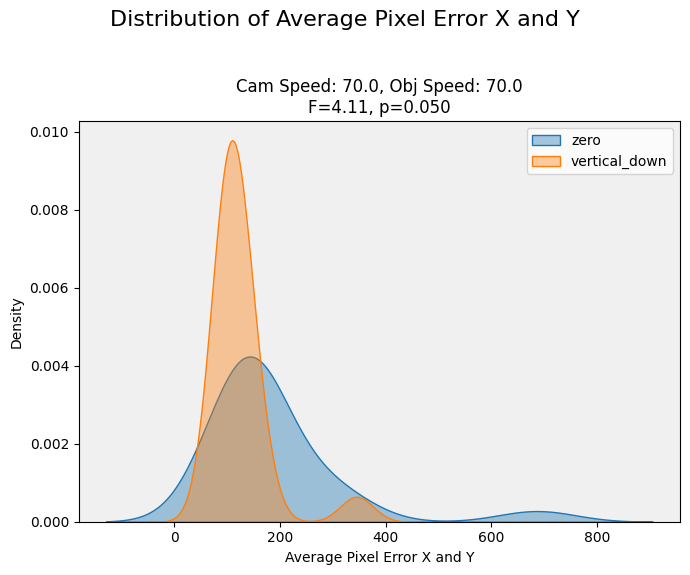

In [276]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns  # For smooth density plots


# Calculate average pixel error per individual trial run across a given time frame for each condition
def calculate_average_error_per_individual_trial(df, 
                                                 time_start=0, 
                                                 time_end=None, 
                                                 object_speed=None, 
                                                 camera_speed=None, 
                                                 object_motion_types=None,
                                                 axis="X"
                                                 ):
    filtered_df = df[(df['RelativeTime'] >= time_start) & (df['RelativeTime'] <= (time_end if time_end is not None else df['RelativeTime'].max()))]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]

    if object_speed is not None:
        filtered_df = filtered_df[filtered_df['object_speed'] == object_speed]
    if camera_speed is not None:
        filtered_df = filtered_df[np.isclose(filtered_df['camera_speed'], camera_speed, rtol=1)]
    if 'direction' in data.columns:  # Ensure the direction column exists
        filtered_df.loc[filtered_df['direction'] == 'right_to_left', 'MappedPogX'] = -filtered_df['MappedPogX'] + screen_width
        filtered_df.loc[filtered_df['direction'] == 'right_to_left', 'BallX'] = -filtered_df['BallX'] + screen_width
    if object_motion_types is not None and len(object_motion_types) != 0:
        filtered_df = filtered_df[filtered_df['object_motion_type'].isin(object_motion_types)]

    filtered_df['PixelError'] = np.sqrt((filtered_df[f'MappedPogX'] - filtered_df[f'BallX'])**2 + (filtered_df[f'MappedPogY'] - filtered_df[f'BallY'])**2)
    
    # Calculate the average pixel error per individual trial run within each TrialID
    avg_error_per_individual_trial = filtered_df.groupby(['camera_motion_type', 'TrialID', 'TrialNumber'])['PixelError'].mean().reset_index()
    return avg_error_per_individual_trial

# Perform ANOVA on the average error per individual trial run across specified camera motion types
def perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=None):
    if camera_motion_types is not None:
        avg_error_per_individual_trial = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'].isin(camera_motion_types)]
    
    # Organize the data by camera motion type for ANOVA
    error_data = [avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'] == motion_type]['PixelError'] 
                  for motion_type in avg_error_per_individual_trial['camera_motion_type'].unique()]
    if len(error_data) > 1:
        f_stat, p_value = f_oneway(*error_data)
        return {'F-statistic': f_stat, 'p-value': p_value}
    else:
        return {'F-statistic': None, 'p-value': None}  # Skip ANOVA if only one group

def analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, axis):
    num_camera_speeds = len(camera_speeds)
    num_object_speeds = len(object_speeds)
    num_combinations = num_camera_speeds * num_object_speeds

    # Create figure and axes
    if num_combinations > 1:
        fig, axes = plt.subplots(num_camera_speeds, num_object_speeds, figsize=(15, 12), sharex=True, sharey=True)
        fig.suptitle(f"Distribution of Average Pixel Error {axis}", fontsize=16)
    else:
        fig, ax = plt.subplots(figsize=(7, 6))
        axes = [[ax]]  # Single plot, wrapped in a nested list to maintain indexing consistency
        fig.suptitle(f"Distribution of Average Pixel Error X and Y", fontsize=16)

    for i, cam_speed in enumerate(camera_speeds):
        for j, obj_speed in enumerate(object_speeds):
            time_start, time_end = time_ranges.get(obj_speed, (0, 4))  # Default time range if not in map

            avg_error_per_individual_trial = calculate_average_error_per_individual_trial(
                data, time_start, time_end, object_speed=obj_speed, camera_speed=cam_speed, object_motion_types=object_motion_types, axis=axis
            )
            print(f'obj: {obj_speed}, cam: {cam_speed}')
            anova_results = perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=camera_motion_types_to_compare)

            # Get the subplot axes
            ax = axes[i][j] if num_combinations > 1 else axes[0][0]

            # Shade the plot background gray if p-value is significant (p < 0.05)
            p_value = anova_results['p-value']
            if p_value is not None and p_value < 0.05:
                ax.set_facecolor('#f0f0f0')  # Light gray background for significant p-values

            # Plot a density plot of average pixel error per individual trial for each camera motion type
            for motion_type in camera_motion_types_to_compare:
                motion_data = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'] == motion_type]
                sns.kdeplot(motion_data['PixelError'], ax=ax, label=f"{motion_type}", fill=True, alpha=0.4)

            # Display ANOVA results in the title of each subplot
            f_stat = anova_results['F-statistic']
            ax.set_title(f"Cam Speed: {cam_speed}, Obj Speed: {obj_speed}\nF={f_stat:.2f}, p={p_value:.3f}")
            ax.set_xlabel("Average Pixel Error X and Y")
            # ax.set_xlim(0, 400)
            ax.set_ylabel("Density")
            ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# Define parameters
time_ranges = {
    15.0: (0.2, 5.0),  
    30.0: (0.2, 3.5),
    70.0: (0.2, 0.8),  
}
camera_motion_types_to_compare = [
    # 'diagonal_left_up_y1', 
    # 'diagonal_left_up_y2', 
    # 'diagonal_left_down_y1', 
    # 'diagonal_left_down_y2', 
    'zero', 
    # 'horizontal_right',
    # 'horizontal_left',
    # 'diagonal_right_up_y1', 
    # 'diagonal_right_up_y2', 
    # 'diagonal_right_down_y1', 
    # 'diagonal_right_down_y2', 
    'vertical_down'
    ]
camera_speeds = [70.0] 
object_speeds = [70.0]

object_motion_types = ['left_to_right']  # Specify the object motion types to filter
# Analyze each combination of camera and object speeds
analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, "Y")


Paired against/with instead of individual

obj: 70.0, cam: 70.0


TypeError: unsupported format string passed to NoneType.__format__

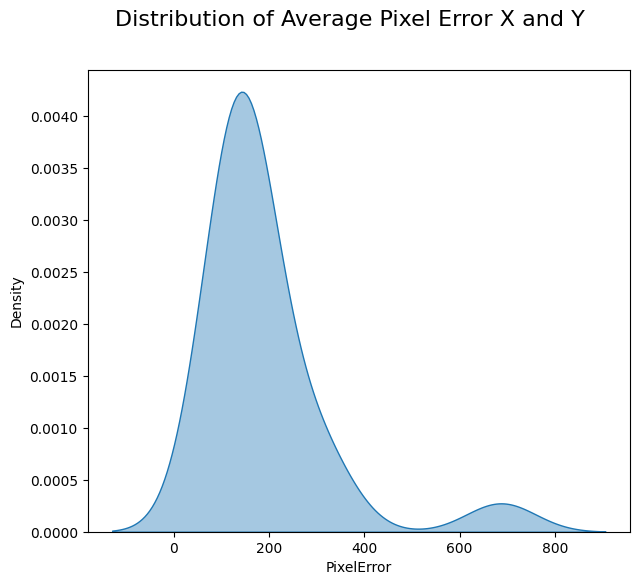

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns  # For smooth density plots


def classify_combined_motion_type(row, pair_conditions):
    """
    Classify the combined motion type based on the object motion type and direction.
    """
    for pair_name, directions in pair_conditions.items():
        for direction, motion_types in directions.items():
            if row['camera_motion_type'] in motion_types and row['object_motion_type'] == direction:
                return pair_name
    return None  # Return None if no match is found

def calculate_average_error_per_individual_trial(df, 
                                                 time_start=0, 
                                                 time_end=None, 
                                                 object_speed=None, 
                                                 camera_speed=None, 
                                                 object_motion_types=None,
                                                 axis="X"):
    # Filter data based on time and validity
    filtered_df = df[(df['RelativeTime'] >= time_start) & 
                     (df['RelativeTime'] <= (time_end if time_end is not None else df['RelativeTime'].max()))]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]

    # Filter based on object and camera speeds
    if object_speed is not None:
        filtered_df = filtered_df[filtered_df['object_speed'] == object_speed]
    if camera_speed is not None:
        filtered_df = filtered_df[np.isclose(filtered_df['camera_speed'], camera_speed, rtol=1)]

    # Adjust for direction for X-axis mappings
    if 'object_motion_type' in df.columns:
        filtered_df.loc[filtered_df['object_motion_type'] == 'right_to_left', 'MappedPogX'] = -filtered_df['MappedPogX'] + screen_width
        filtered_df.loc[filtered_df['object_motion_type'] == 'right_to_left', 'BallX'] = -filtered_df['BallX'] + screen_width

    # Filter based on object motion types
    if object_motion_types is not None and len(object_motion_types) != 0:
        filtered_df = filtered_df[filtered_df['object_motion_type'].isin(object_motion_types)]

    # Add combined motion type column
    filtered_df['camera_combined_motion_types'] = filtered_df.apply(
        classify_combined_motion_type, axis=1, pair_conditions=pair_conditions
    )

    # Compute pixel error
    filtered_df['PixelError'] = np.sqrt(
        (filtered_df['MappedPogX'] - filtered_df['BallX'])**2 + 
        (filtered_df['MappedPogY'] - filtered_df['BallY'])**2
    )

    # Calculate the average pixel error grouped by combined motion type, TrialID, and TrialNumber
    avg_error_per_individual_trial = filtered_df.groupby(
        ['camera_combined_motion_types', 'TrialID', 'TrialNumber']
    )['PixelError'].mean().reset_index()

    return avg_error_per_individual_trial

# Perform ANOVA on the average error per individual trial run across specified camera motion types
def perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=None):
    if camera_motion_types is not None:
        avg_error_per_individual_trial = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_combined_motion_types'].isin(camera_motion_types)]
    
    # Organize the data by camera motion type for ANOVA
    error_data = [avg_error_per_individual_trial[avg_error_per_individual_trial['camera_combined_motion_types'] == motion_type]['PixelError'] 
                  for motion_type in avg_error_per_individual_trial['camera_combined_motion_types'].unique()]
    
    if len(error_data) > 1:
        f_stat, p_value = f_oneway(*error_data)
        return {'F-statistic': f_stat, 'p-value': p_value}
    else:
        return {'F-statistic': None, 'p-value': None}  # Skip ANOVA if only one group

def analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, axis):
    num_camera_speeds = len(camera_speeds)
    num_object_speeds = len(object_speeds)
    num_combinations = num_camera_speeds * num_object_speeds

    # Create figure and axes
    if num_combinations > 1:
        fig, axes = plt.subplots(num_camera_speeds, num_object_speeds, figsize=(15, 12), sharex=True, sharey=True)
        fig.suptitle(f"Distribution of Average Pixel Error {axis}", fontsize=16)
    else:
        fig, ax = plt.subplots(figsize=(7, 6))
        axes = [[ax]]  # Single plot, wrapped in a nested list to maintain indexing consistency
        fig.suptitle(f"Distribution of Average Pixel Error X and Y", fontsize=16)

    for i, cam_speed in enumerate(camera_speeds):
        for j, obj_speed in enumerate(object_speeds):
            time_start, time_end = time_ranges.get(obj_speed, (0, 4))  # Default time range if not in map

            avg_error_per_individual_trial = calculate_average_error_per_individual_trial(
                data, time_start, time_end, object_speed=obj_speed, camera_speed=cam_speed, object_motion_types=object_motion_types, axis=axis
            )
            print(f'obj: {obj_speed}, cam: {cam_speed}')
            anova_results = perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=camera_motion_types_to_compare)

            # Get the subplot axes
            ax = axes[i][j] if num_combinations > 1 else axes[0][0]

            # Shade the plot background gray if p-value is significant (p < 0.05)
            p_value = anova_results['p-value']
            if p_value is not None and p_value < 0.05:
                ax.set_facecolor('#f0f0f0')  # Light gray background for significant p-values

            # Plot a density plot of average pixel error per individual trial for each camera motion type
            for motion_type in camera_motion_types_to_compare:
                motion_data = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_combined_motion_types'] == motion_type]
                sns.kdeplot(motion_data['PixelError'], ax=ax, label=f"{motion_type}", fill=True, alpha=0.4)

            # Display ANOVA results in the title of each subplot
            f_stat = anova_results['F-statistic']
            ax.set_title(f"Cam Speed: {cam_speed}, Obj Speed: {obj_speed}\nF={f_stat:.2f}, p={p_value:.3f}")
            ax.set_xlabel("Average Pixel Error X and Y")
            ax.set_ylabel("Density")
            ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# Define parameters
time_ranges = {
    15.0: (0.2, 5.0),  
    30.0: (0.2, 3.5),
    70.0: (0.2, 0.8),  
}
camera_motion_types_to_compare = [
    # 'diagonal_with_y1', 
    # 'diagonal_with_y2', 
    # 'horizontal_with',
    # 'diagonal_against_y1', 
    # 'diagonal_against_y2', 
    # 'horizontal_against',
    # 'zero', 
    # 'horizontal_right',
    # 'diagonal_right_up_y1', 
    # 'diagonal_right_up_y2', 
    # 'diagonal_right_down_y1', 
    # 'diagonal_right_down_y2', 
    # 'vertical_down'
    ]
camera_speeds = [70.0] 
object_speeds = [70.0]

object_motion_types = ['left_to_right']  # Specify the object motion types to filter
# Analyze each combination of camera and object speeds
analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, "Y")
